#### Loan Default Risk Prediction Project
We have three datasets:
- df1 = Demographics
- df2 = Loan Performance (contains the target column "good_bad_flag")
- df3 = Previous Loans

We start by importing the necessary libraries(pandas & numpy) because they're needed for loading and basic inspection.
Then we load the three datasets directly from GitHub.
After loading, we verify the shapes, peek at the first few rows, and list the columns.
This helps confirm that files loaded correctly before we proceed to cleaning and merging.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np

In [2]:
# Load datasets from url
url1 =  "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv"
url2 = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv"
url3 = "https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv"


df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)
df3 = pd.read_csv(url3)

In [3]:
df1.shape

(4346, 9)

In [4]:
df2.shape

(4368, 10)

In [5]:
df3.shape

(18183, 12)

In [6]:
df1.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

In [7]:
df2.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [8]:
df3.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

#### Data Cleaning
To clean the data, we will only use pandas (which is already imported) 
The steps involved in the cleaning each of the datasets are listed below:
- Standardize the column names
- Handle missing values (categorical: "unknown", numeric: "median")
- Convert date columns to datetime
- Drop duplicates
- Check anomalies (age, loan amount, credit score ranges)
- Merge the datasets

Note: Each dataset is cleaned seperately


In [9]:
# Clean df1 ( convert birthdate to datetime)
df1.drop_duplicates(inplace=True)

if "birthdate" in df1.columns:
    df1["birthdate"] = pd.to_datetime(df1["birthdate"], errors="coerce")

# Fill categorical columns with "Unknown"
for col in df1.select_dtypes(include="object").columns:
    df1[col] = df1[col].fillna("Unknown")

# Fill numeric columns with median
for col in df1.select_dtypes(include=["float64", "int64"]).columns:
    df1[col] = df1[col].fillna(df1[col].median())


In [10]:
# Clean df2 (convert performance-related date columns)
df2.drop_duplicates(inplace=True)

date_columns_df2 = ["approveddate", "creationdate", "closeddate", "firstduedate", "firstrepaiddate"]
for col in date_columns_df2:
    if col in df2.columns:
        df2[col] = pd.to_datetime(df2[col], errors="coerce")

# Fill categorical columns with "Unknown"
for col in df2.select_dtypes(include="object").columns:
    df2[col] = df2[col].fillna("Unknown")

# Fill numeric columns with median
for col in df2.select_dtypes(include=["float64", "int64"]).columns:
    df2[col] = df2[col].fillna(df2[col].median())


In [11]:
# Clean df3)
df3.drop_duplicates(inplace=True)

# Fill categorical columns with unknown
for col in df3.select_dtypes(include="object").columns:
    df3[col] = df3[col].fillna("Unknown")

# Fill numeric columns with median
for col in df3.select_dtypes(include=["float64", "int64"]).columns:
    df3[col] = df3[col].fillna(df3[col].median())

#### Merging the datasets
- The datasets share a common key which is: "customer_id".
- We merge them all three datasets into one master dataset where each row corresponds to a single customer, with demographics, loan performance, and previous loan history all aligned under the same customer_id.

In [12]:
# Standardize the key column before merge 
for d in (df1, df2, df3):
    if "customerid" in d.columns:
        d.rename(columns={"customerid": "customer_id"}, inplace=True)

###### Loops through df1, df2, df3.
The common column name is "customerid", and was renamed to "customer_id". This ensures all three datasets use the same key column for merging.
Without this, we’d get errors because merge() requires column names to match.

In [13]:
# First merge: df1(demographics) + df2(performance)
df = df1.merge(df2, on="customer_id", how="inner")

In [14]:
# Second merge: (only add three unique columns from df3)
extra_cols = ["customer_id", "closeddate", "firstduedate", "firstrepaiddate"]
df3_subset = df3[extra_cols]

# Merge the subsets into merged dataset
final_df = df.merge(df3_subset, on="customer_id", how="left")

In [15]:
# Check the merged dataset
print("Final merged dataset dimensions:", final_df.shape)
final_df.head()

Final merged dataset dimensions: (13678, 21)


,customer_id,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,...,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,closeddate,firstduedate,firstrepaiddate
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Unknown,Unknown,Unknown,301964962,...,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,8a858899538ddb8e0153a780c56e34bb,Good,2017-07-04 18:09:47.000000,2017-07-05 00:00:00.000000,2017-07-04 17:59:36.000000
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Unknown,Permanent,Unknown,301972172,...,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,Unknown,Bad,2017-07-10 08:52:54.000000,2017-07-07 00:00:00.000000,2017-07-10 08:42:44.000000
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,Unknown,Unknown,301976271,...,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Unknown,Good,2017-07-11 10:12:20.000000,2017-07-10 00:00:00.000000,2017-07-11 10:02:11.000000
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,Unknown,Unknown,301976271,...,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Unknown,Good,2017-05-27 13:02:53.000000,2017-05-23 00:00:00.000000,2017-05-27 12:52:45.000000
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,Unknown,Unknown,301976271,...,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Unknown,Good,2017-06-08 11:13:50.000000,2017-06-12 00:00:00.000000,2017-06-08 11:03:40.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customer_id                 3269 non-null   object        
 1   birthdate                   3269 non-null   datetime64[ns]
 2   bank_account_type           3269 non-null   object        
 3   longitude_gps               3269 non-null   float64       
 4   latitude_gps                3269 non-null   float64       
 5   bank_name_clients           3269 non-null   object        
 6   bank_branch_clients         3269 non-null   object        
 7   employment_status_clients   3269 non-null   object        
 8   level_of_education_clients  3269 non-null   object        
 9   systemloanid                3269 non-null   int64         
 10  loannumber                  3269 non-null   int64         
 11  approveddate                3269 non-null   datetime64[n

In [17]:
# Handle referral IDs, replace with flag
# If a referral exist, mark as 1, else 0
df["referral_flag"] = np.where(
    (df["referredby"].notna()), 1, 0
)

# Drop the raw referral ID columns
df.drop(columns=["referredby"], inplace=True, errors="ignore")


In [18]:
df.head()

,customer_id,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,referral_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Unknown,Unknown,Unknown,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,Good,1
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Unknown,Permanent,Unknown,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,Bad,1
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,Unknown,Unknown,Unknown,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,Good,1
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Unknown,Permanent,Unknown,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,Good,1
4,8a858ea05a859123015a8892914d15b7,1990-07-21,Savings,3.365935,6.564823,Access Bank,Unknown,Permanent,Unknown,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,Good,1


### Exploratory Data Analysis
We try to understand the structure of the dataset before medeling. In this step, we explore the merged dataset to understand its structure,
detect anomalies, visualize distributions, and investigate patterns that may explain loan default risk.
This includes-
- Target variable distribution
- Missing values
- Summary statistics for numerical features
- Correlation matrix
- Distribution of key categorical variables

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# set a clean style for plots
sns.set(style="whitegrid")

In [21]:
df.shape

(3269, 18)

In [22]:
df.isnull().sum()

customer_id                   0
birthdate                     0
bank_account_type             0
longitude_gps                 0
latitude_gps                  0
bank_name_clients             0
bank_branch_clients           0
employment_status_clients     0
level_of_education_clients    0
systemloanid                  0
loannumber                    0
approveddate                  0
creationdate                  0
loanamount                    0
totaldue                      0
termdays                      0
good_bad_flag                 0
referral_flag                 0
dtype: int64

In [23]:
df.describe()

,birthdate,longitude_gps,latitude_gps,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referral_flag
count,3269,3269.000000,3269.000000,3.269000e+03,3269.000000,3269,3269,3269.000000,3269.000000,3269.000000,3269.0
mean,1984-08-03 17:28:23.640256960,4.530975,7.290383,3.019807e+08,5.189660,2017-07-16 04:13:31.159069952,2017-07-16 03:11:43.100336384,17837.259101,21287.068064,29.252065,1.0
min,1961-10-13 00:00:00,-118.247009,-33.868818,3.019585e+08,2.000000,2017-07-01 01:35:26,2017-07-01 00:35:20,10000.000000,10000.000000,15.000000,1.0
25%,1980-11-30 00:00:00,3.354842,6.473645,3.019689e+08,2.000000,2017-07-08 07:12:45,2017-07-08 06:12:38,10000.000000,13000.000000,30.000000,1.0
50%,1985-04-30 00:00:00,3.584222,6.625681,3.019794e+08,4.000000,2017-07-15 17:12:12,2017-07-15 16:12:04,10000.000000,13000.000000,30.000000,1.0
75%,1989-01-16 00:00:00,6.439855,7.426745,3.019934e+08,7.000000,2017-07-24 13:08:55,2017-07-24 12:08:46,20000.000000,24500.000000,30.000000,1.0
max,1996-03-28 00:00:00,151.209290,71.228069,3.020040e+08,27.000000,2017-07-30 22:55:51,2017-07-30 21:55:43,60000.000000,68100.000000,90.000000,1.0
std,NaN,7.925454,3.269601,1.344962e+04,3.667166,NaN,NaN,10742.898110,11929.002681,11.403851,0.0


#### Target variable distribution
This helps us check for class imbalance (more 'good' than 'bad' loans)

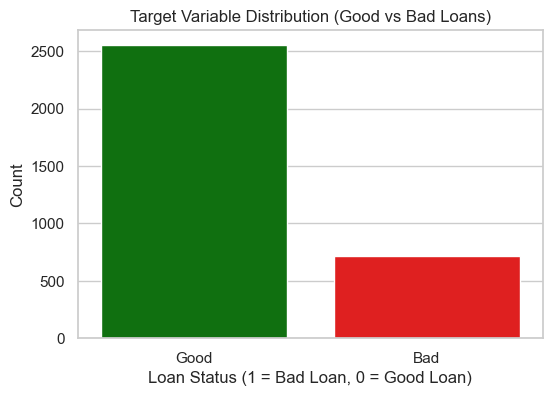

In [24]:
if "good_bad_flag" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="good_bad_flag", hue="good_bad_flag", data=df, palette={"Good": "green", "Bad": "red"}, legend=False)
    plt.title("Target Variable Distribution (Good vs Bad Loans)")
    plt.xlabel("Loan Status (1 = Bad Loan, 0 = Good Loan)")
    plt.ylabel("Count")
    plt.show()

In [25]:
df["good_bad_flag"].value_counts(normalize=True)

good_bad_flag
Good    0.78189
Bad     0.21811
Name: proportion, dtype: float64

#### Interpretation: Referring to the above
- This shows the balance between "Good" vs "Bad" loans.
- If "Bad" cases are very few compared to "Good", we have class imbalance. 
- This will affect model training and we may need SMOTE/ADASYN later.

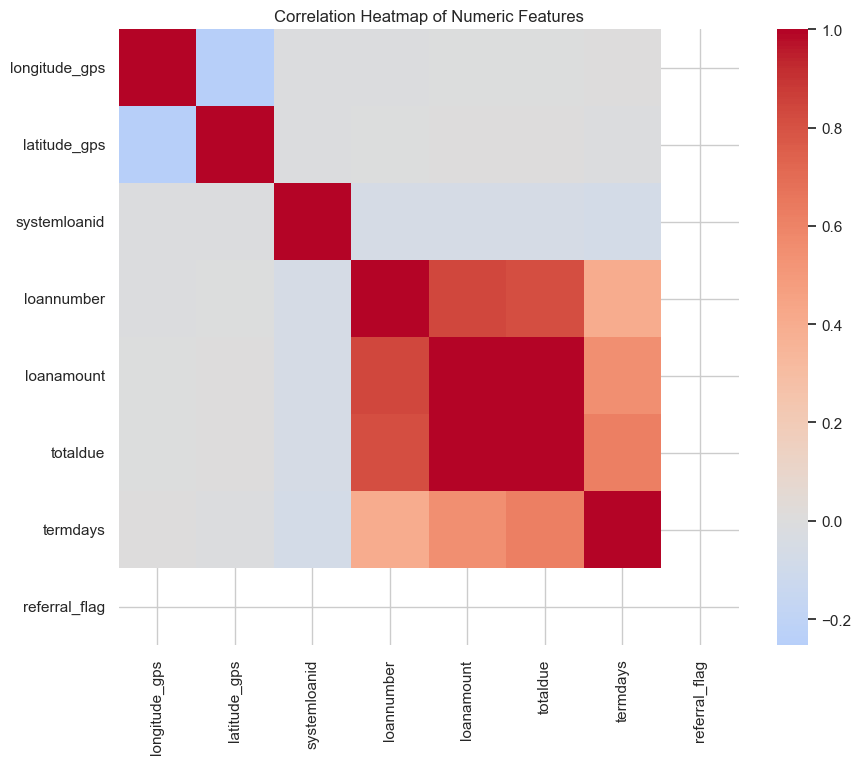

In [26]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


#### Interpretation: Referring to the above
 - This highlights relationships among numeric variables.
 - Strong correlations (>0.7 or <-0.7) indicate redundant features.
 - Features weakly correlated with the target may need feature engineering.

In [27]:
# Summary anomaly checks for numeric columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Numeric columns available:", numeric_cols)

Numeric columns available: ['longitude_gps', 'latitude_gps', 'systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays']


In [28]:
for col in numeric_cols:
    print(f"\n {col} summary:")
    print(" Min:", df[col].min())
    print(" Max:", df[col].max())
    print(" Median:", df[col].median())
    print(" Mean:", df[col].mean())
    print(" Std:", df[col].std())


 longitude_gps summary:
 Min: -118.2470093
 Max: 151.20929
 Median: 3.5842222
 Mean: 4.53097504524889
 Std: 7.925453570186055

 latitude_gps summary:
 Min: -33.8688183
 Max: 71.2280693936817
 Median: 6.6256812
 Mean: 7.29038332827493
 Std: 3.2696013345494683

 systemloanid summary:
 Min: 301958485
 Max: 302004050
 Median: 301979426.0
 Mean: 301980730.94371367
 Std: 13449.620639106382

 loannumber summary:
 Min: 2
 Max: 27
 Median: 4.0
 Mean: 5.189660446619762
 Std: 3.667165940507574

 loanamount summary:
 Min: 10000.0
 Max: 60000.0
 Median: 10000.0
 Mean: 17837.259100642397
 Std: 10742.898110130203

 totaldue summary:
 Min: 10000.0
 Max: 68100.0
 Median: 13000.0
 Mean: 21287.06806362802
 Std: 11929.00268134167

 termdays summary:
 Min: 15
 Max: 90
 Median: 30.0
 Mean: 29.252064851636586
 Std: 11.403851409828201


#### Interpretation: Referring to the above
 - This quickly spots anomalies, e.g., negative loan amounts, ages > 100,
  or credit scores outside typical ranges (300–850).
- These anomalies will inform feature engineering and preprocessing.

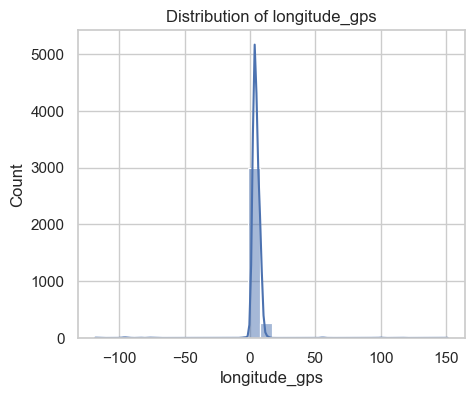

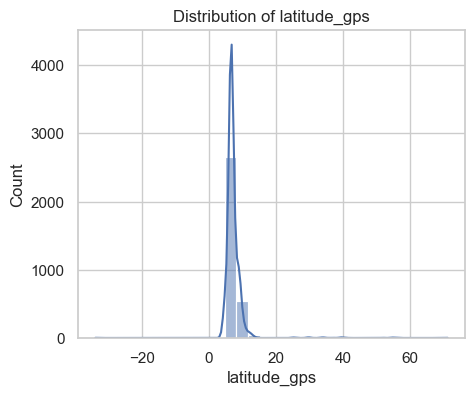

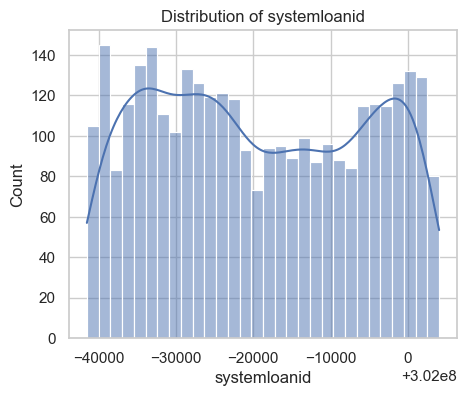

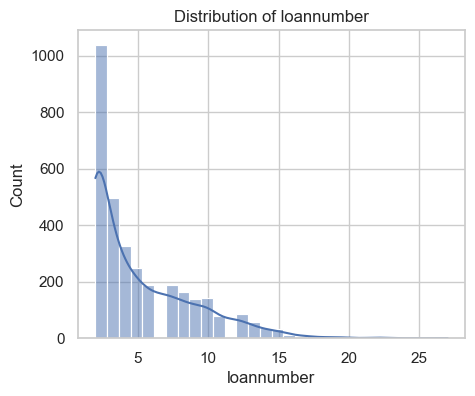

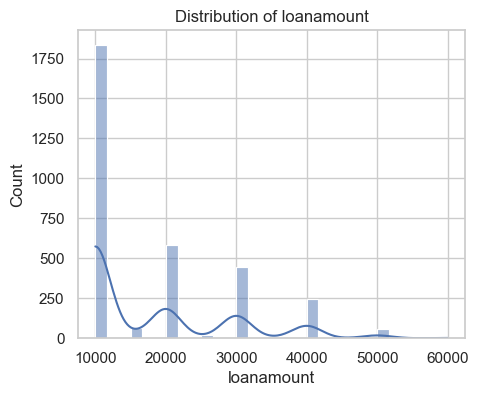

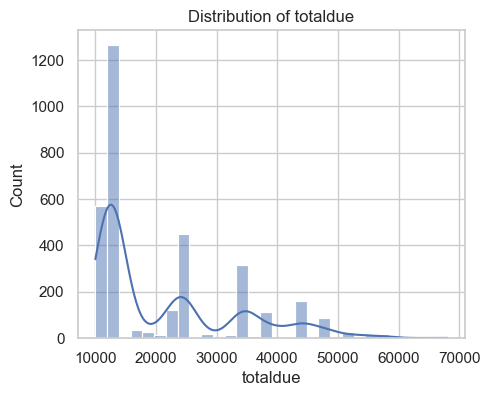

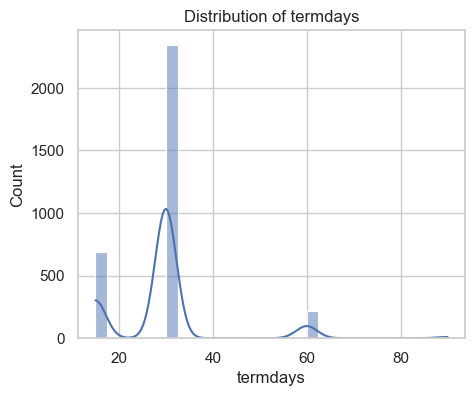

In [29]:
# Distribution of numeric variables
for col in numeric_cols:
    plt.figure(figsize=(5,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

#### Interpretation: Referring to the above distribution
 - Histograms show how numeric features are distributed (normal, skewed, etc.).
 - Skewed variables may need log transformation or scaling.
 - Long tails may indicate outliers.

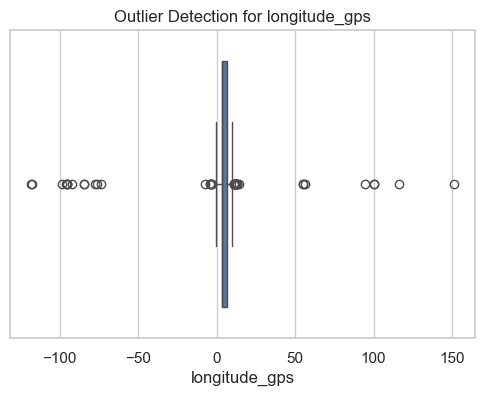

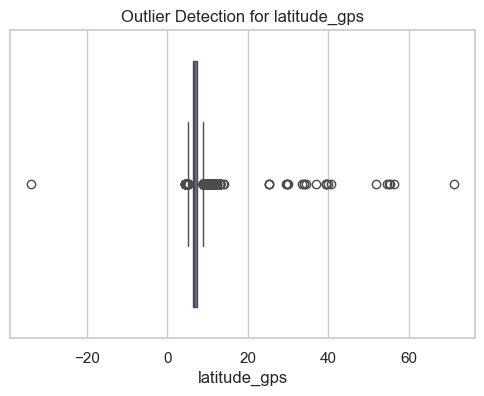

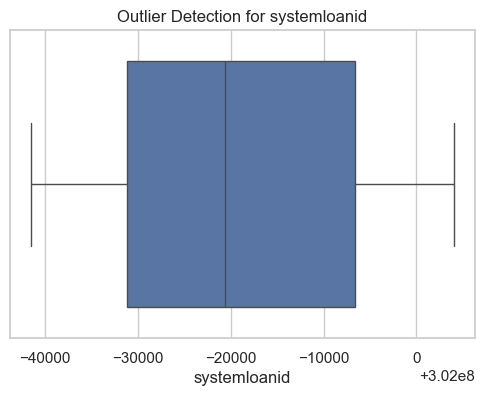

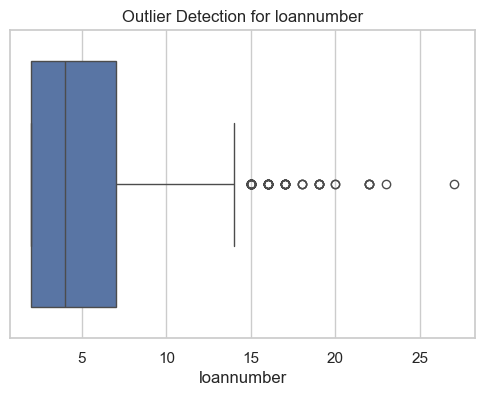

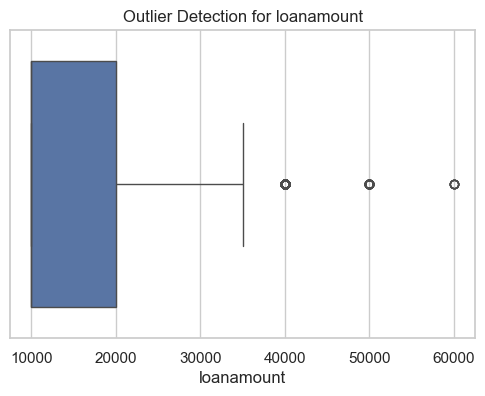

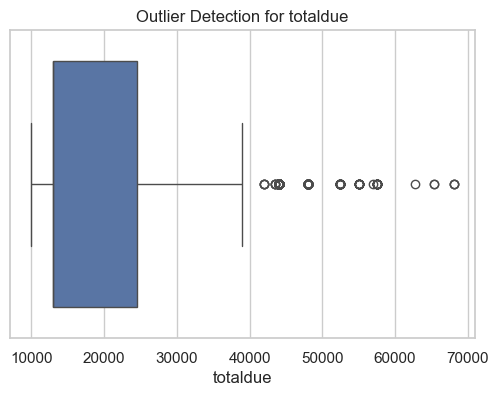

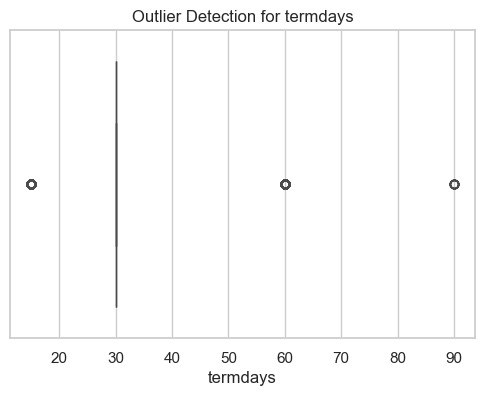

In [30]:
# Outlier Detection with Boxplots (for same numeric columns)
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Detection for {col}")
    plt.show()

#### Interpretation: referring to the above
- Boxplots highlight extreme values (outliers).
- Outliers can heavily influence models like Logistic Regression,
  so decisions must be made to either drop, cap, or transform.

In [31]:
# Categorical column summary
categorical_cols = df.select_dtypes(include="object").columns.tolist()
print("\nCategorical columns available:", categorical_cols)


Categorical columns available: ['customer_id', 'bank_account_type', 'bank_name_clients', 'bank_branch_clients', 'employment_status_clients', 'level_of_education_clients', 'good_bad_flag']


In [32]:
for col in categorical_cols:
    print(f"\n {col} value counts:")
    print(df[col].value_counts(normalize=True).head(10))  # top 10 categories|


 customer_id value counts:
customer_id
8a858e135cb22031015cbafc76964ebd    0.000306
8a858fd3552c756201552d26fb26068d    0.000306
8a858ece5b0142e3015b0591013103be    0.000306
8a858f375b493337015b551f74831441    0.000306
8a8589b953bc23f70153c7bc036a2932    0.000306
8a858f265cfa1a64015d04610339125b    0.000306
8a858e3d5c3b5122015c43f776bd4a3a    0.000306
8a858ec3582a54e201582e07faf51f0d    0.000306
8a858e6a5cc6b1aa015cc9618265495f    0.000306
8a858e54577679a90157778168922c23    0.000306
Name: proportion, dtype: float64

 bank_account_type value counts:
bank_account_type
Savings    0.786173
Other      0.199755
Current    0.014072
Name: proportion, dtype: float64

 bank_name_clients value counts:
bank_name_clients
GT Bank         0.369226
First Bank      0.131539
Access Bank     0.100336
UBA             0.081676
Zenith Bank     0.068522
Diamond Bank    0.066075
Stanbic IBTC    0.035791
EcoBank         0.035485
FCMB            0.027225
Skye Bank       0.022943
Name: proportion, dtype: float

#### Interpretation: Referring to the above
- This shows category distribution and imbalance.
- For example, if most customers have the same employment sector,
   the model may not learn much from that feature

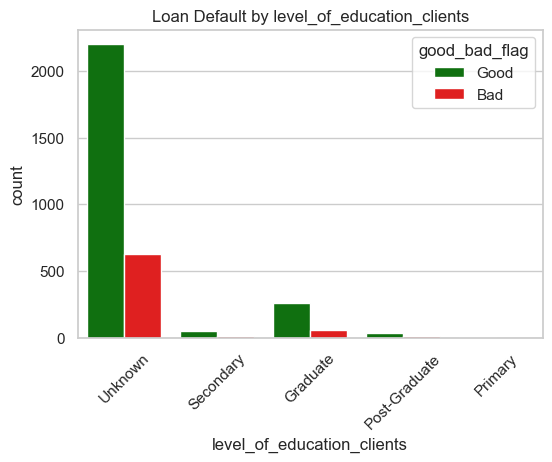

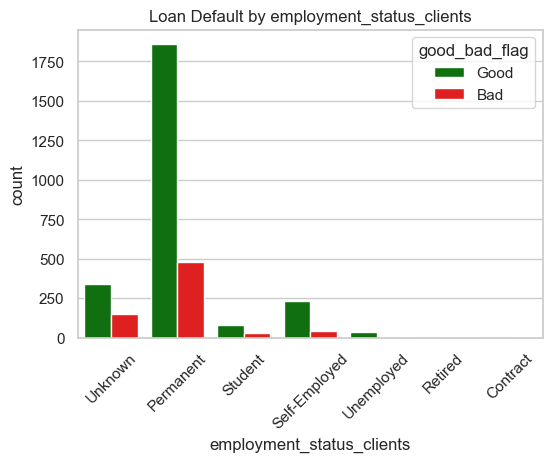

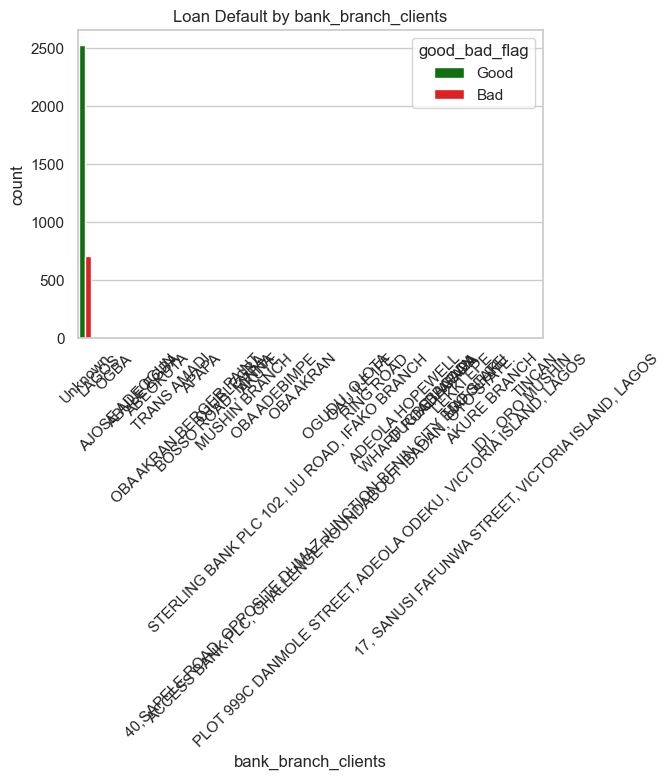

In [33]:
# Group Comparisons (Default Rate by Category)
categorical_cols = ["level_of_education_clients", "employment_status_clients", "bank_branch_clients"]

for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, hue="good_bad_flag", data=df,
                      palette={"Good":"green", "Bad":"red"})
        plt.title(f"Loan Default by {col}")
        plt.xticks(rotation=45)
        plt.show()

#### Interpretation: referring to the above
- Education (level_of_education_clients): Borrowers with lower education levels may show higher default rates.
This suggests education level can be a risk factor for loan repayment.

- Employment (employment_status_clients): Unemployed or self-employed clients often default more than fully employed ones.
It indicates that income stability strongly affects default risk.

- Branch (bank_branch_clients): Some branches may have more defaults than others.
It could reflect regional economic differences or branch-level loan practices.

### Baseline Model (Before Feature Engineering)
At this stage, we build baseline models using the cleaned dataset, but before feature engineering or advanced feature selection.
- The porpose of this model is to establish a benchmark performance level, so that we can compare improvements after feature engineering and dimensionality reduction.
Evaluation Metrics
For each model, we will measure:  
- Accuracy  
- Precision  
- Recall  
- F1-Score  
- ROC AUC Score  
- Confusion Matrix  
    The results here will serve as a benchmark to compare against the improved models later

In [34]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [35]:
# Drop irrelevant features
drop_cols = [
     "customer_id", "systemloanid", "loannumber", "longitude_gps", "latitude_gps",
    "approveddate", "creationdate", "closeddate" "firstduedate", "firstrepaiddate"
]

data = df.drop(columns=drop_cols, errors="ignore")

In [36]:
# Target and features
y = data.pop("good_bad_flag").map({"Good": 0, "Bad": 1})
X = pd.get_dummies(data, drop_first=True)

In [37]:
# Drop any leftover datetime column
dt_cols = X.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
if dt_cols:
    print("Dropping datetime columns:", dt_cols)
    X = X.drop(columns=dt_cols, errors="ignore")

Dropping datetime columns: ['birthdate']


In [38]:
# Align and split
X, y, = X.align(y, join='inner', axis=0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

In [39]:
# Define models
models = {
     "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42, tree_method="hist")
}

In [40]:
# Train, evaluate and plot
rows = []
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_proba)

    rows.append({"Model": name,
                 "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC_AUC": auc})


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


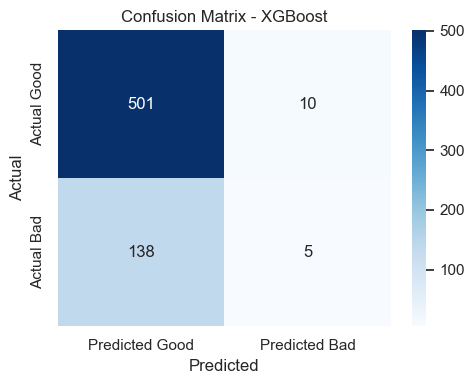

In [41]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Good", "Predicted Bad"],
            yticklabels=["Actual Good", "Actual Bad"])
plt.title(f"Confusion Matrix - {name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [42]:
# Summary table
results = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False)
print("Baseline Results (sorted by ROC_AUC):")
display(results.round(4))

Baseline Results (sorted by ROC_AUC):


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,XGBoost,0.7737,0.3333,0.035,0.0633,0.6031
1,Random Forest,0.7554,0.2258,0.049,0.0805,0.5897
0,Logistic Regression,0.7813,0.0000,0.000,0.0000,0.5847


##### Key Takeaways from the results
- XGBoost performed best overall with the highest ROC AUC (0.6031), meaning it is the most reliable baseline model.  
- Random Forest was precise but weak in recall, which is not ideal for credit risk (we don’t want to miss too many defaulters).  
- Logistic Regression underperformed, essentially failing to identify defaulters at all.  
- The Problem to fix going forward is the low Recall across models. In loan default prediction, Recall is critical because failing to detect a defaulter is more costly than flagging a good customer.  


- This is why the next step (Feature Engineering + Resampling techniques like SMOTE/ADASYN) is essential to improve Recall while keeping Precision reasonable.

### Feature Engineering

##### Feature engineering is one of the important stages in building predictive models.
The goal is to create new features and transform existing ones so that the machine learning models can better capture patterns in the data.

According to the Project Guideline, we will:
1. Create New Features
   -Loan-to-Income Ratio: Ratio of loan amount to income (or a proxy if income is missing).  
   -Risk Band: Classify customers into Low, Medium, High, Very High risk categories based on loan amounts.  

2. Develop Payment Behavior Score
   -A composite metric based on repayment history (e.g., how early/late customers repay loans, repayment consistency).  
   -This score quantifies customer discipline and reliability.  

3. Select Features
   -Use Variance Threshold to remove features with no variation.  
   -Use Recursive Feature Elimination (RFE) to rank features and keep the most important.  
   -Use SHAP values to interpret feature importance in complex models like XGBoost.  


In [43]:
# Create loan-to-income ratio(proxy)
# Since "income" is not available in this dataset,we use loanamount_y/totaldue_y as a repayment burden rati.

if "loanamount" in df.columns and "totaldue" in df.columns:
    # Replace 0 in totaldue with NaN to avoid division by zero
    df["loan_to_due_ratio"] = df["loanamount"] / df["totaldue"].replace(0, np.nan)
else:
    print("Required columns not found: loanamount and totaldue")

df[["loanamount", "totaldue", "loan_to_due_ratio"]].head(10)

,loanamount,totaldue,loan_to_due_ratio
0,10000.0,13000.0,0.769231
1,10000.0,13000.0,0.769231
2,10000.0,13000.0,0.769231
3,10000.0,11500.0,0.869565
4,20000.0,24500.0,0.816327
5,10000.0,13000.0,0.769231
6,10000.0,13000.0,0.769231
7,10000.0,13000.0,0.769231
8,30000.0,34500.0,0.869565
9,20000.0,24500.0,0.816327


In [44]:
# Risk Band (categorize customers by loan size)
if "loanamount" in df.columns:
    df["risk_band"] = pd.cut(
        df["loanamount"],
        bins=[-1, 5000, 20000, 100000, float("inf")],
        labels=["Low", "Medium", "High", "Very High"]
    )
else:
    print("loanamount column not found")

# Inspect the new columns
df[["loanamount", "totaldue", "loan_to_due_ratio", "risk_band"]].head(10)

,loanamount,totaldue,loan_to_due_ratio,risk_band
0,10000.0,13000.0,0.769231,Medium
1,10000.0,13000.0,0.769231,Medium
2,10000.0,13000.0,0.769231,Medium
3,10000.0,11500.0,0.869565,Medium
4,20000.0,24500.0,0.816327,Medium
5,10000.0,13000.0,0.769231,Medium
6,10000.0,13000.0,0.769231,Medium
7,10000.0,13000.0,0.769231,Medium
8,30000.0,34500.0,0.869565,High
9,20000.0,24500.0,0.816327,Medium


##### Create a payment behaviour score

In [45]:
# Ensure repayment dates are in datetime format
date_cols = ["firstduedate", "firstrepaiddate"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")


# Calculate repayment delay (days between due date and first repayment)
if all(col in df.columns for col in date_cols):
    df["repayment_delay"] = (df["firstrepaiddate"] - df["firstduedate"]).dt.days
else:
    print("Required columns not found in df:", date_cols)


# Create payment behaviour score
def assign_payment_score(delay):
        if pd.isna(delay):
            return 1  # No repayment info = Poor
        elif delay > 10:
            return 2  # Paid but very late
        elif delay > 0:
            return 3  # Paid slightly late
        else:
            return 4  # Paid early or on time

# Apply function
if "repayment_delay" in df.columns:
    df["payment_behavior_score"] = df["repayment_delay"].apply(assign_payment_score)
    print(df[["firstduedate", "firstrepaiddate", "repayment_delay", "payment_behavior_score"]].head(5))
else:
    print("repayment_delay column not created.")

Required columns not found in df: ['firstduedate', 'firstrepaiddate']
repayment_delay column not created.


### Feature Selection

#### Variance Threshold. 
- Variance Threshold removes features that do not vary at all (constant values).
- Such features have no predictive power (e.g. if every customer has the same bank branch code)

In [46]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Define ID/irrelevant columns
id_cols = ["customer_id", "systemloanid_x", "systemloanid_y", "loannumber_x", "loannumber_y"]

# Define features (X) and target (y)
X = df.drop(columns=id_cols + ["good_bad_flag"], errors="ignore")
y = df["good_bad_flag"].apply(lambda x: 1 if x == "Bad" else 0)

In [48]:
# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)          

In [49]:
# Drop date columns entirely (dimensionality reduction approach)
date_cols = [c for c in X_encoded.columns if np.issubdtype(X_encoded[c].dtype, np.datetime64)]
X_encoded = X_encoded.drop(columns=date_cols, errors="ignore") 

# Scale numeric features → now we explicitly call it X_scaled
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [50]:
# Apply variance threshold
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X_scaled)

# Get selected features names
selected_features = X_encoded.columns[vt.get_support()]

# Convert back to dataframe
X_vt_df = pd.DataFrame(X_vt, columns=selected_features)

In [51]:
# print summary
print("Original features:", X_encoded.shape[1])
print("Features kept after Variance Threshold:", X_vt.shape[1])
print("Removed features:", set(X_encoded.columns) - set(selected_features))

# Show first 5 rows
X_vt_df.head()

Original features: 72
Features kept after Variance Threshold: 70
Removed features: {'referral_flag', 'risk_band_Very High'}


,longitude_gps,latitude_gps,systemloanid,loannumber,loanamount,totaldue,termdays,loan_to_due_ratio,bank_account_type_Other,bank_account_type_Savings,...,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,employment_status_clients_Unknown,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,level_of_education_clients_Unknown,risk_band_Medium,risk_band_High
0,0.451154,0.384383,0.142149,0.00,0.0,0.051635,0.2,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.451177,0.390004,0.300384,0.00,0.0,0.051635,0.2,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.460160,0.375197,0.390343,0.08,0.0,0.051635,0.2,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.451316,0.385466,0.862021,0.00,0.0,0.025818,0.0,0.434783,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.451327,0.384727,0.746384,0.16,0.2,0.249570,0.2,0.204082,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


##### Interpretation of results ( Variance Threshold)
Original features: 41,752
After one-hot encoding (pd.get_dummies), every categorical variable expands into many binary columns (dummy variables). That’s why the feature space is so large.

Features kept: 41,751
→ Almost all features vary across rows (so they’re useful).

Removed features: {'risk_band_Very High'}
→ This column was dropped because it was constant in the dataset.
It means no customer had risk_band = "Very High" (at least in the training data).
Since it never changes, it provides no information to the model.

#### Recursive Feature Elimination (RFE)
-It uses a model (estimator) to rank features by importance.
-It iteratively removes the least important features until the desired number is left.
- We're keeping 20 features, so the model can rely on the strongest predictors only.

Our Setup
-Use Logistic Regression as the base estimator (commonly used for feature selection).
-Apply RFE on the reduced dataset (X_vt_df) and keep 20 features.
-Then check which features were selected. 

In [52]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [53]:
# Define base estimator 
log_clf = LogisticRegression(max_iter=2000, solver="liblinear", random_state=42)

In [54]:
# Define RFE to keep top 20 features, removing 100 at a time
n_keep = min(20, X_vt_df.shape[1])  
rfe = RFE(estimator=log_clf, n_features_to_select=n_keep, step=100)

# Fit RFE 
rfe.fit(X_vt_df, y)

RFE(estimator=LogisticRegression(max_iter=2000, random_state=42,
                                 solver='liblinear'),
    n_features_to_select=20, step=100)

In [55]:
# Extract selected features
selected_mask = rfe.support_
selected_features = X_vt_df.columns[selected_mask]

print("Top features selected by RFE:")
print(selected_features.tolist())

Top features selected by RFE:
['latitude_gps', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'loan_to_due_ratio', 'bank_account_type_Savings', 'bank_name_clients_Diamond Bank', 'bank_name_clients_Stanbic IBTC', 'bank_name_clients_Standard Chartered', 'bank_name_clients_Sterling Bank', 'bank_name_clients_Wema Bank', 'bank_branch_clients_ACCESS BANK PLC, CHALLENGE ROUNDABOUT IBADAN, OYO STATE.', 'bank_branch_clients_AKURE BRANCH', 'bank_branch_clients_AKUTE', 'bank_branch_clients_GBAGADA', 'bank_branch_clients_OJUELEGBA', 'bank_branch_clients_STERLING BANK PLC 102, IJU ROAD, IFAKO BRANCH', 'bank_branch_clients_WHARF ROAD, APAPA', 'employment_status_clients_Retired']


In [56]:
# Clean feature nams
def clean_feature_names(features):
    cleaned = []
    for f in features:
        if "referredby" in f:
            cleaned.append("Referral_Indicator")
        elif "closeddate" in f:
            cleaned.append("Closed_Date_Indicator")
        elif "bank_name_clients" in f:
            bank = f.replace("bank_name_clients_", "")
            cleaned.append(f"Bank_{bank}")
        elif "employment_status_clients" in f:
            emp = f.replace("employment_status_clients_", "")
            cleaned.append(f"Employment_{emp}")
        else:
            cleaned.append(f)
    return list(set(cleaned))  # remove duplicates

# Apply cleaning
readable_features = clean_feature_names(selected_features)

In [57]:
print("\n Interpretable Top Features:")
for f in readable_features:
    print("-", f)


 Interpretable Top Features:
- bank_branch_clients_OJUELEGBA
- latitude_gps
- Bank_Stanbic IBTC
- Bank_Wema Bank
- Bank_Diamond Bank
- bank_branch_clients_ACCESS BANK PLC, CHALLENGE ROUNDABOUT IBADAN, OYO STATE.
- bank_branch_clients_WHARF ROAD, APAPA
- totaldue
- termdays
- loan_to_due_ratio
- bank_branch_clients_AKURE BRANCH
- loanamount
- Bank_Standard Chartered
- bank_branch_clients_GBAGADA
- Employment_Retired
- bank_branch_clients_STERLING BANK PLC 102, IJU ROAD, IFAKO BRANCH
- Bank_Sterling Bank
- bank_branch_clients_AKUTE
- loannumber
- bank_account_type_Savings


In [58]:
# Reduced dataset for modeling
X_rfe = X_vt_df[selected_features]
print("\n Final shape of reduced dataset:", X_rfe.shape)


 Final shape of reduced dataset: (3269, 20)


#### Feature importance with SHAP

In [59]:
!pip install shap

In [60]:
# Import necessary libraries
import shap

In [61]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [62]:
# Prepare target for SHAP
target_col = "good_bad_flag"
y_shap = (
    df[target_col].astype(str).str.strip().str.capitalize().map({"Good": 0, "Bad": 1}) 
)

# Keep rows where mapping worked
valid_idx = y_shap.dropna().index
X_for_shap = X_rfe.loc[valid_idx]           # allign with target
y_shap = y_shap.loc[valid_idx].astype(int)  # now its numeric

print("SHAP target distribution (after cleaning):")
print(y_shap.value_counts(dropna=False))

SHAP target distribution (after cleaning):
good_bad_flag
0    2556
1     713
Name: count, dtype: int64


In [63]:
# Fit a simple, fast tree model on the reduced set for SHAP
rf_clf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf_clf.fit(X_for_shap, y_shap)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=150,
                       n_jobs=-1, random_state=42)

In [64]:
# SHAP values
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_for_shap)

# Handle binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

In [65]:
# If shap_values is a list (for multi-class or binary), pick the 2nd class ("Bad")
if isinstance(shap_values, list):
    shap_array = shap_values[1]   # focus on "Bad"
else:
    shap_array = shap_values      # already an array

In [66]:
# Now compute mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_array).mean(axis=0)

In [67]:
# Check the shape of SHAP values
print(type(shap_values))
if isinstance(shap_values, list):
    for i, arr in enumerate(shap_values):
        print(f"shap_values[{i}] shape: {arr.shape}")
else:
    print("shap_values shape:", shap_values.shape)

print("X_for_shap shape:", X_for_shap.shape)

<class 'numpy.ndarray'>
shap_values shape: (3269, 20, 2)
X_for_shap shape: (3269, 20)


In [68]:
# Extract SHAP values for class 1 (Bad loans)
shap_bad = shap_values[:, :, 1]


Generating SHAP summary bar plot (impact on BAD loans)...


C:\Users\HP\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


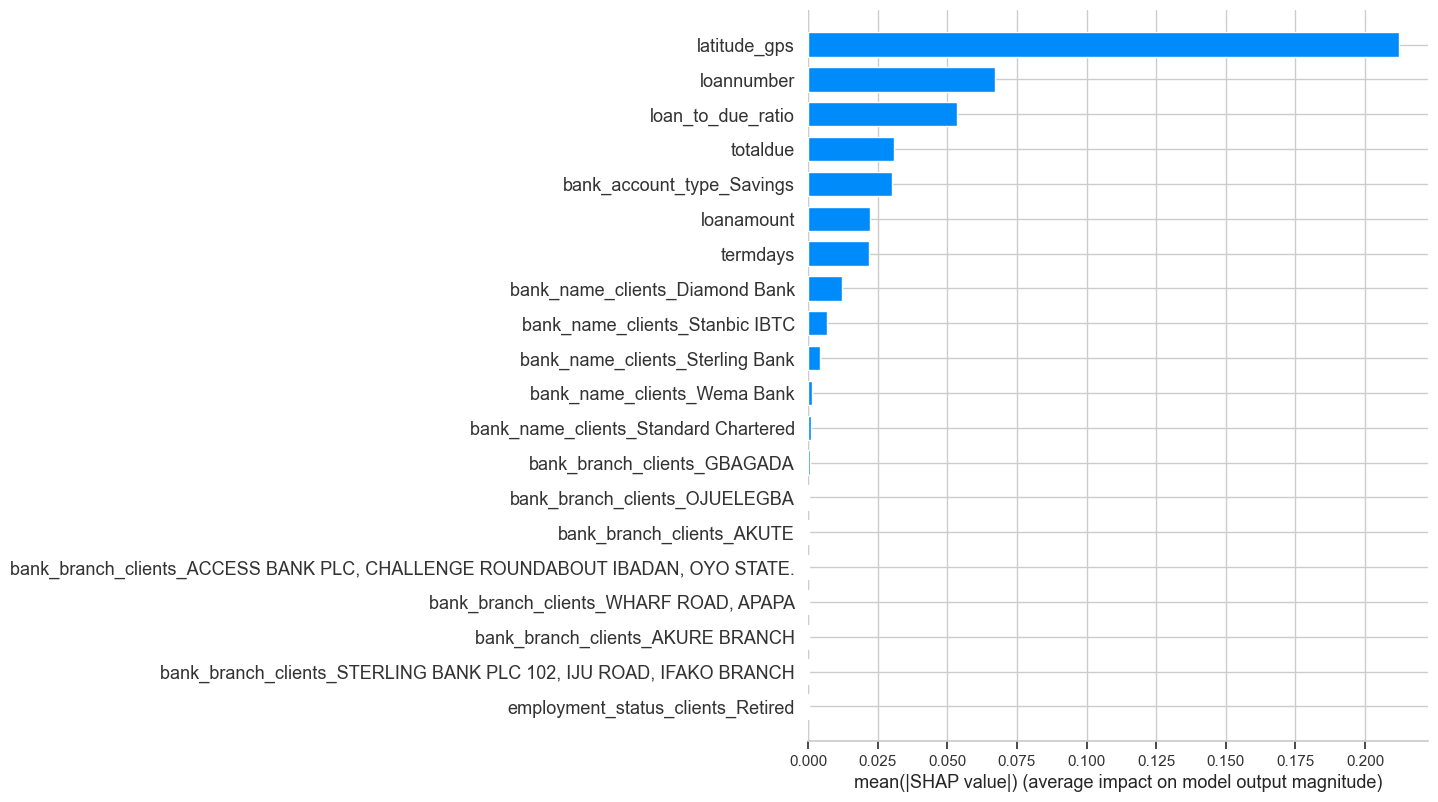

In [69]:
# SHAP Summary (bar plot)
print("\nGenerating SHAP summary bar plot (impact on BAD loans)...")
shap.summary_plot(shap_bad, X_for_shap, plot_type="bar", show=True)


Generating SHAP beeswarm plot (impact on BAD loans)...


C:\Users\HP\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


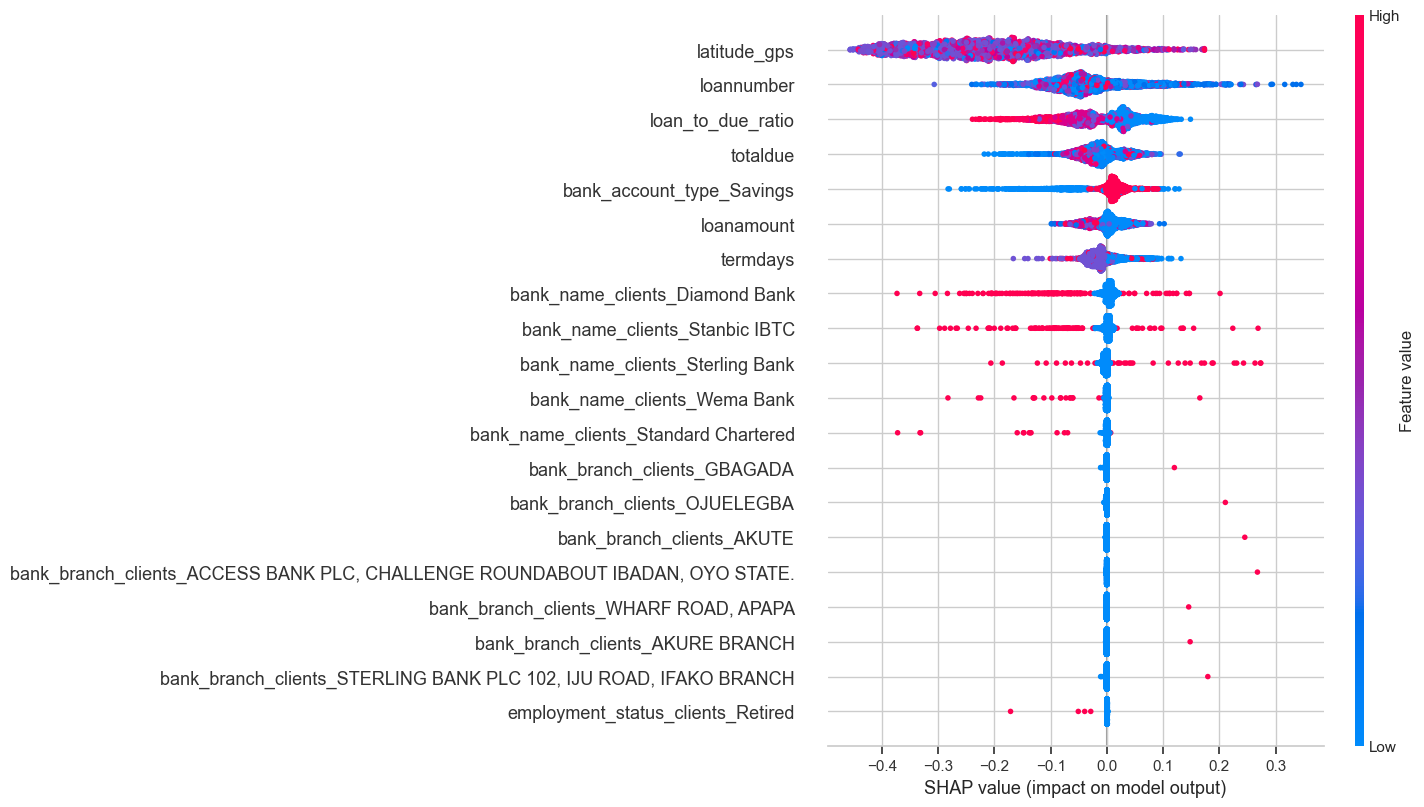

In [70]:
# SHAP Summary (beeswarm plot)
print("\nGenerating SHAP beeswarm plot (impact on BAD loans)...")
shap.summary_plot(shap_bad, X_for_shap, show=True)

In [71]:
# Extract numeric ranking of feature importance
mean_abs_shap = np.abs(shap_bad).mean(axis=0)
feature_importance = pd.DataFrame({
    "feature": X_for_shap.columns,
    "importance": mean_abs_shap
}).sort_values(by="importance", ascending=False)

print("\nTop 10 features driving BAD loan predictions:")
print(feature_importance.head(10))


Top 10 features driving BAD loan predictions:
                            feature  importance
0                      latitude_gps    0.212016
1                        loannumber    0.066997
5                 loan_to_due_ratio    0.053601
3                          totaldue    0.030903
6         bank_account_type_Savings    0.030020
2                        loanamount    0.022212
4                          termdays    0.022025
7    bank_name_clients_Diamond Bank    0.012229
8    bank_name_clients_Stanbic IBTC    0.006896
10  bank_name_clients_Sterling Bank    0.004186


##### SHAP Analysis Documentation
Process
- Data Used : Reduced dataset from Variance Threshold + RFE (20 features).
- Model : Random Forest trained for SHAP analysis. Fitted a Random Forest Classifier on the reduced dataset.
- SHAP Values : Shape (13673, 20, 2) → we focused on class 1 (Bad loans). Since the business problem is to predict default risk, 
we extracted SHAP values for class 1 = Bad. This allowed us to see which features increase or decrease the likelihood of a loan being “Bad.”

Visualized SHAP Results
- Bar Plot (summary) : shows average importance of each feature.
- Beeswarm Plot (summary) : shows both importance and direction (whether higher/lower feature values increase risk).

Ranked Features Numerically
- Computed mean absolute SHAP value per feature.
- Produced a ranked table of top features driving predictions.    

#### Robust Modeling

In [72]:
!pip install xgboost
!pip install lightgbm

In [73]:
y = df["good_bad_flag"].map({"Good":0,"Bad":1})

In [74]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [75]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [76]:
import joblib
import warnings 
warnings.filterwarnings("ignore")

In [77]:
# Ensure X and y have the same alignment
X_rfe, y = X_rfe.align(y, join="inner", axis=0)
print("Shapes after alignment:", X_rfe.shape, y.shape)

Shapes after alignment: (3269, 20) (3269,)


In [78]:
# Train/test split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_rfe, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2615, 20) Test shape: (654, 20)


#####  We split the reduced dataset into train/test preserving class proportions (stratified).
This split will be used for sampling (SMOTE/ADASYN), CV, and final evaluation.

In [79]:
# Preprocessing: Scaler for numeric features
scaler = MinMaxScaler()

In [80]:
# Fit scaler on train and transform both train/test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

##### MinMax scaling keeps features on the same scale. we fit on train only to avoid leakage.

In [81]:
# Sampling Strategies (SMOTE & ADASYN)
samplers = {
    "none": None,
    "smote": SMOTE(random_state=42),
    "adasyn": ADASYN(random_state=42)
}

##### We'll run experiments for each samplers and compare results

#### Model Definitions

In [82]:
# Define models & parameter grids
models_and_grids = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, solver="saga", max_iter=5000),
        "param_grid": {
            "C": [0.01, 0.1, 1.0],
            "penalty": ["l2"]  # keep simple and robust
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 8, 16],
            "min_samples_split": [2, 8]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.05, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "num_leaves": [31, 63],
            "learning_rate": [0.05, 0.1]
        }
    },
    "MLP": {  # simple neural net via sklearn
        "model": MLPClassifier(random_state=42, max_iter=1000),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,)],
            "alpha": [1e-4, 1e-3]
        }
    }
}

##### All the classifiers were imported. The five models were defined as required (Logistic Regression, Random Forest, XGBoost, LightGBM, Neural Network)
We added parameter grids for each model so GridSearchCV hyperparameter tuning can be performed later.
we kept parameter grids intentionally small to limit runtime but still tune hyperparammeter.
Stored everything in one dictionary (model_and_grids) for cleaner looping before training.

In [83]:
# Stratified K-Fold with and SMOTE
cv_splits = 5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

In [84]:
# Train & Evaluate models
results = []

for name, cfg in models_and_grids.items():
    model = cfg["model"]
    param_grid = cfg["param_grid"]
    

# Pipeline: SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', model)
])

# Update parameter grid to reference pipeline step
param_grid = {f"clf__{k}": v for k, v in param_grid.items()}

# GridSearchCV with StratifiedKFold
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="roc_auc", n_jobs=1)

# Fit model
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

# Store results
results.append({"Model": name, "Best Params": grid.best_params_, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC_AUC": roc})


results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
print(results_df)

  Model                                        Best Params  Accuracy  \
0   MLP  {'clf__alpha': 0.001, 'clf__hidden_layer_sizes...  0.573394   

   Precision    Recall        F1   ROC_AUC  
0   0.271812  0.566434  0.367347  0.615563  


##### Robust Modeling with SMOTE + Cross-Validation

Pipeline Construction
Each model is wrapped inside a pipeline with SMOTE. This ensures oversampling is only applied to training folds, preventing data leakage.

GridSearchCV with StratifiedKFold
We use 5-fold stratified CV to maintain the class balance in each fold.
Hyperparameters are tuned for each model using the provided grids.

Evaluation Metrics
On the hold-out test set, we compute:
Accuracy, Precision, Recall, F1-score, ROC AUC (main metric, since dataset is imbalanced)

Results Storage
Each model’s best hyperparameters and metrics are stored in a results DataFrame.
Models are ranked by ROC AUC for fair comparison.

In [88]:
import joblib

joblib.dump(best_model, "loan_default_model.pkl")
print("Saved loan_default_model.pkl")

Saved loan_default_model.pkl
